**Notebook showcasing evaluation of data**


In [ ]:
# This is the path to the helper functions folder
# On drive for example: '/content/drive/My Drive/myfolder/helper_functions'
modules_path = './helper_functions'
models_path = './models' # for the models folder

# This is the path to the data folder
# On drive for example: '/content/drive/myfolder/data'
base_path = './data/'

# This is the path to the tensorflow checkpoint folder
# On drive for example: '/content/drive/MyDrive/best_models'
checkpoint_filepath = './best_models'

In [ ]:
# pip calls
!pip install tensorflow_addons

# all the nice imports <3
import os
import math
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import h5py
import numpy as np
from datetime import datetime
import keras
import importlib
import pickle

# black magic, so that tf.Tensor objects can be used as numpy things
# all hail tensorflow 0_0
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# show important library versions
print("TensorFlow version: {}".format(tf.__version__))
print("TensorFlow Datasets version: ",tfds.__version__)

# import & mount drive
from google.colab import drive
drive.mount('/content/drive')

# hardware speed-up magic (TPU OR GPU?)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('Warning: GPU device not found')
else:  
  print('Found GPU at: {}'.format(device_name))

# Tensorboard stuff (callbacks for logging data)
%load_ext tensorboard
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


# add custom paths (to import the nice models and helper classes)
import sys
sys.path.append(models_path)
sys.path.append(modules_path)

# add custom imports here
import processing
import metrics
import conv_architectures as ca

In [ ]:
dataset_size = '1000'
size = '64' # or 32 or 64
n = 64

base_path = '/content/drive/MyDrive/Bachelor Thesis/data/'
size_path = size + 'x' + size + '/'
model_base_path = '/content/drive/MyDrive/Bachelor Thesis/normal_convnets/' + size_path

cr_array = np.array(['0.1000', '0.0500', '0.0200', '0.0100', '0.0050', '0.0020'])

for cr in cr_array:

  data_path = base_path + size_path + 'n=' + size + '_x=' + dataset_size + '_cr=' + cr + '_DS.h5'
  tp_data_path = base_path + size_path + 'n=' + size + '_x=' + dataset_size + '_cr=' + cr + '_TP.h5'

  
  f = h5py.File(data_path, 'r')
  imgs = np.array(f['images'])
  labs = np.array(f['c_vectors'])
  f.close()

  dataproc = processing.Processing(
          imgs, 
          labs, 
          np.array([0.8,0.1,0.1]), 
          custom_valid = None,
          custom_test = None,
          batch_size=256, 
          conv_behavior=True, 
          scale_labels=False, 
          symmetric=True, 
          twopoint=True,
          shuffle=False,
          pca=False,
          # pca_variance=0.7
          )
  
  plt.subplot(1, 2, 1)
  plt.imshow(imgs[0].reshape((n,n)))
  plt.subplot(1, 2, 2)
  plt.imshow(dataproc.images[0].reshape((n,n)))

  
  hf = h5py.File(tp_data_path, 'w')
  hf.create_dataset('twopoint', data=dataproc.images)
  hf.close()

In [ ]:
cr = '0.0200'
dataset_size = '10000'
size = '32'
base_path = '/content/drive/MyDrive/Bachelor Thesis/data/'
size_path = size + 'x' + size + '/'
data_path = base_path + size_path + 'n=' + size + '_x=' + dataset_size + '_cr=' + cr + '_DS.h5'
tp_data_path = base_path + size_path + 'n=' + size + '_x=' + dataset_size + '_cr=' + cr + '_TP.h5'

f = h5py.File(data_path, 'r')
imgs = np.array(f['images'])
labs = np.array(f['c_vectors'])
f.close()

tp_f = h5py.File(tp_data_path, 'r')
tp_imgs = np.array(tp_f['twopoint'])
tp_f.close()

dataproc = processing.Processing(
        imgs, 
        labs, 
        np.array([0.8,0.1,0.1]), 
        custom_valid = None,
        custom_test = None,
        batch_size=256, 
        conv_behavior=True, 
        scale_labels=False, 
        symmetric=True, 
        twopoint=np.False_,
        shuffle=False,
        pca=False,
        # pca_variance=0.7
        )

In [ ]:
# EXAMPLE OF RESULTS
path_to_results = './PROBLEM_FOLDER/32x32/history/all_data_PROBLEM'
with open(path_to_results, 'rb') as f:
    results = pickle.load(f)

**Evaluation of Predictions and Print One Image**

In [ ]:
model_res = results[0]

model_func = model_res['model_function'](dataproc)
model_func.load_weights(model_res['path_to_weights'])
one_img, one_lab = dataproc.get_one_pair()

pred = model_func.predict(one_img.reshape(1,32,32,1))
print("Showing an image with id: " + str(int(one_lab[0])))
print(dataproc.six_to_nine(np.squeeze(pred)).reshape(3,3))
print(dataproc.six_to_nine(one_lab).reshape(3,3))
print(one_lab - pred)

plt.imshow(one_img.reshape(32,32))
plt.axis('off')
plt.savefig("./img"+str(int(one_lab[0])), bbox_inches='tight', pad_inches=0, dpi=200)

**Evaluate variance kept**

In [ ]:
# PCA Reduction, function from Stackoverflow
def pca_dataset(data, number_dims=None):
  """
  returns: data transformed in 2 dims/columns + regenerated original data
  pass in: data as 2D NumPy array
  """
  
  m, n = data.shape
  # mean center the data
  data -= data.mean(axis=0)
  # calculate the covariance matrix
  R = np.cov(data, rowvar=False)
  # calculate eigenvectors & eigenvalues of the covariance matrix
  # use 'eigh' rather than 'eig' since R is symmetric, 
  # the performance gain is substantial
  evals, evecs = np.linalg.eigh(R)
  # sort eigenvalue in decreasing order
  idx = np.argsort(evals)[::-1]
  evecs = evecs[:,idx]
  # sort eigenvectors according to same index
  evals = evals[idx]

  if number_dims != None:
    red_evecs = evecs[:,:number_dims]
    red_evals = evals[:number_dims]

  frac_variance = np.sum(red_evals) / np.sum(evals)
  # carry out the transformation on the data using eigenvectors
  # and return the re-scaled data, eigenvalues, and eigenvectors
  return np.dot(red_evecs.T, data.T).T,frac_variance

In [ ]:
path_ds16 = './data/' + '16x16/' + 'n=16' + '_x=10000' + '_cr=0.0200' + '_DS.h5'
path_ds32 = './data/' + '32x32/' + 'n=32' + '_x=10000' + '_cr=0.0200' + '_DS.h5'

f16 = h5py.File(path_ds16, 'r')
imgs16 = np.array(f16['images'])
f16.close()

f32 = h5py.File(path_ds32, 'r')
imgs32 = np.array(f32['images'])
f32.close()

_,frac16 = pca_dataset(imgs16, number_dims=32)
_,frac32 = pca_dataset(imgs32, number_dims=128)

print("16x16 kept: " + str(frac16) + " and 32x32 kept: " + str(frac32) + " fraction of total variance")

16x16 kept: 0.6707733311105334 and 32x32 kept: 0.8556718522320511 fraction of total variance


**Formatting functions for model names**

In [ ]:
def format_2pc(res):
  mn = '$'+res['model_name'].upper()[0] + "$, "
  if res['twopoint']:
    mn = mn + "with 2PC, "
  else:
    mn = mn + "no 2PC, "
  mn = mn + "$CR = " + str(int(1 / float(res['contrast_ratio']))) + '$'
  return mn

def format_autoencoder(res):
  mn = "DS = " + str(res['ds_size']) + ", 2PC: " + str(res['twopoint'])
  return mn

def format_pcaae(res):
  name = ''

  if res['model_name'] == 'PCA':
    name = 'PCA'
  elif res['model_name'] == 'frozenE':
    name = 'Frozen AE'
  elif res['model_name'] == 'freeE':
    name = 'Free AE'
  else:
    name = 'Unknown Model'
  mn = name + ', 2PC: ' + str(res['twopoint'])
  return mn

def formatmisc(res):
  return res['model_name']

def format_cr(res):
  return res['model_name'].upper()[0] + ", $CR = " + str(int(1 / float(res['contrast_ratio']))) + "$"

def format_ds(res):
  return res['model_name'].upper()[0] + ", DS = " + str(res['ds_size'])

Plot stuff

0.0100
pretrained & 0.5989286303520203 & \\
0.0100
untrained & 0.6047328114509583 & \\


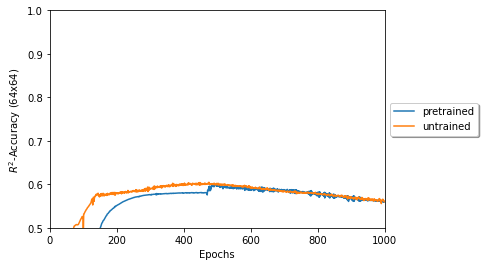

In [ ]:
# Example paths
path_to_results = './normal_convnets/32x32/history/all_data_DS'
path_to_autoencoder = './autoencoders/32x32/history/all_data_AUTOENCODER'
path_to_pcaae = './pca_ae/history/all_data_HAM'
with open(path_to_pcaae, 'rb') as f:
    results = pickle.load(f)

length = len(results[0]['history']['val_r_square'])
epochs = np.linspace(1,length, num=length)
size = '64'

for res in results:
  print(res['contrast_ratio'])
  # mn = format_cr(res)
  # mn = format_2pc(res)
  # mn = format_autoencoder(res)
  # mn = format_pcaae(res)
  # mn = format_ds(res)
  mn = formatmisc(res)
  y = res['history']['val_r_square']
  if True:
    print(mn, "&", np.max(y), '& \\\\')
    plt.plot(epochs,y, label=mn)

# plt.legend(loc='right')

ax = plt.gca()
ax.set_xlim([0, length])
ax.set_ylim([0.5,1])
ax.set_xlabel("Epochs")
ax.set_ylabel("$R^2$-Accuracy ("+size+"x"+size+")".format())
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fancybox=True)
# ax.legend(loc='center right', shadow=True, fancybox=True)

plt.savefig('./ds_size32_all_plot', dpi=200, bbox_inches='tight')

plt.show()